### Packages

In [3]:
!pip install pmdarima 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 26.8 MB/s 
     |████████████████████████████████| 9.9 MB 45.0 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [4]:
!pip install arch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 903 kB 29.1 MB/s 


In [5]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.3 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [6]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from arch import arch_model
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()

## Loading the data

In [7]:
raw_data = yfinance.download (tickers = "^GSPC ^FTSE ^N225 ^GDAXI", start = "1994-01-07", 
                              end = "2019-09-01", interval = "1d", group_by = 'ticker', auto_adjust = True, treads = True)

[*********************100%***********************]  4 of 4 completed


In [8]:
df_comp = raw_data.copy()

In [9]:
df_comp['spx'] = df_comp['^GSPC'].Close[:]
df_comp['dax'] = df_comp['^GDAXI'].Close[:]
df_comp['ftse'] = df_comp['^FTSE'].Close[:]
df_comp['nikkei'] = df_comp['^N225'].Close[:]

In [10]:
df_comp = df_comp.iloc[1:]
del df_comp['^N225']
del df_comp['^GSPC']
del df_comp['^GDAXI']
del df_comp['^FTSE']
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')

## Creating Returns

In [11]:
df_comp['ret_spx'] = df_comp.spx.pct_change(1).mul(100)
df_comp['ret_ftse'] = df_comp.ftse.pct_change(1).mul(100)
df_comp['ret_dax'] = df_comp.dax.pct_change(1).mul(100)
df_comp['ret_nikkei'] = df_comp.nikkei.pct_change(1).mul(100)

In [12]:
df_comp['norm_ret_spx'] = df_comp.ret_spx.div(df_comp.ret_spx[1])*100
df_comp['norm_ret_ftse'] = df_comp.ret_ftse.div(df_comp.ret_ftse[1])*100
df_comp['norm_ret_dax'] = df_comp.ret_dax.div(df_comp.ret_dax[1])*100
df_comp['norm_ret_nikkei'] = df_comp.ret_nikkei.div(df_comp.ret_nikkei[1])*100

## Splitting the Data

In [13]:
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

## Fitting a Model

In [14]:
model_ar = ARIMA(df.ftse, order = (1,0,0))
results_ar = model_ar.fit()

## Simple Forecasting

In [15]:
df.tail()

,spx,dax,ftse,nikkei,ret_spx,ret_ftse,ret_dax,ret_nikkei,norm_ret_spx,norm_ret_ftse,norm_ret_dax,norm_ret_nikkei
,,,,,,,,,,,,
Date,,,,,,,,,,,,
2014-07-09,1972.829956,9808.200195,6718.000000,15302.650391,0.464427,-0.304222,0.363568,-0.076789,-193.623849,39.056133,260.939581,-33.873062
2014-07-10,1964.680054,9659.129883,6672.399902,15216.469727,-0.413107,-0.678775,-1.519854,-0.563175,172.228229,87.141370,-1090.828512,-248.427258
2014-07-11,1967.569946,9666.339844,6690.200195,15164.040039,0.147092,0.266775,0.074644,-0.344559,-61.324138,-34.248669,53.573442,-151.991545
2014-07-14,1977.099976,9783.009766,6746.100098,15296.820312,0.484355,0.835549,1.206971,0.875626,-201.932230,-107.268090,866.266436,386.255523
2014-07-15,1973.280029,9719.410156,6710.500000,15395.160156,-0.193210,-0.527714,-0.650103,0.642878,80.550866,67.748084,-466.591262,283.585757


In [16]:
# create variables that will help us change the periods easily instead of typing them up every time
# make sure the start and end dates are business days, otherwise the code will result in an error
start_date = "2014-07-15"
end_date = "2015-01-01"

In [17]:
end_date = "2019-10-23"
df_pred = results_ar.predict(start = start_date, end = end_date)

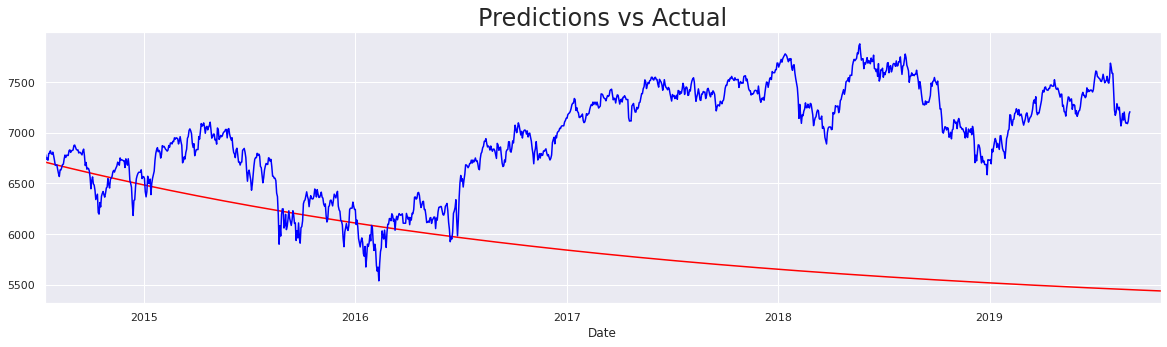

In [18]:
df_pred[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()

### Using Returns Instead

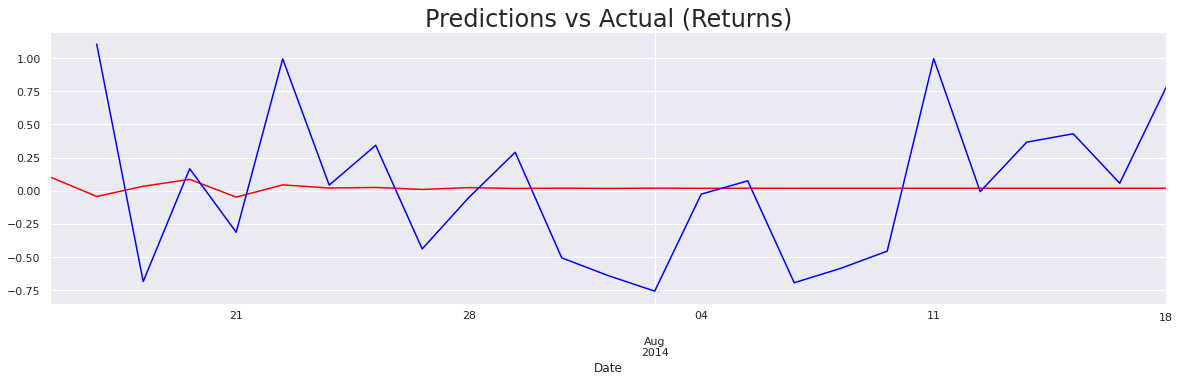

In [19]:
end_date = "2014-08-18"

model_ret_ar = ARIMA(df.ret_ftse[1:], order = (5,0,0))
results_ret_ar = model_ret_ar.fit()

df_pred_ar = results_ret_ar.predict(start = start_date, end = end_date) 

df_pred_ar[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

In [20]:
results_ret_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               ret_ftse   No. Observations:                 5351
Model:                     ARMA(5, 0)   Log Likelihood               -8306.931
Method:                       css-mle   S.D. of innovations              1.143
Date:                Sat, 19 Nov 2022   AIC                          16627.862
Time:                        09:06:46   BIC                          16673.958
Sample:                    01-11-1994   HQIC                         16643.963
                         - 07-15-2014                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0192      0.013      1.434      0.152      -0.007       0.045
ar.L1.ret_ftse    -0.0214      0.014     -1.566      0.117      -0.048       0.005
ar.L2.ret_ftse    -0.0524      0.014     -3.841      0.000      -0.079      -0.026
ar.L3.ret_ftse    -0.0804      0.014     -5.903      0.000      -0.107      -0.054
ar.L4.ret_ftse     0.0423      0.014      3.100      0.002       0.016       0.069
ar.L5.ret_ftse    -0.0572      0.014     -4.189      0.000      -0.084      -0.030
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.5638           -0.0000j            1.5638           -0.5000
AR.2           -0.2936           -1.7419j            1.7665           -0.2766
AR.3           -0.2936           +1.7419j            1.7665            0.2766
AR.4            1.4453           -1.2231j            1.8934           -0.1118
AR.5            1.4453           +1.2231j            1.8934            0.1118
-----------------------------------------------------------------------------
"""

### MA

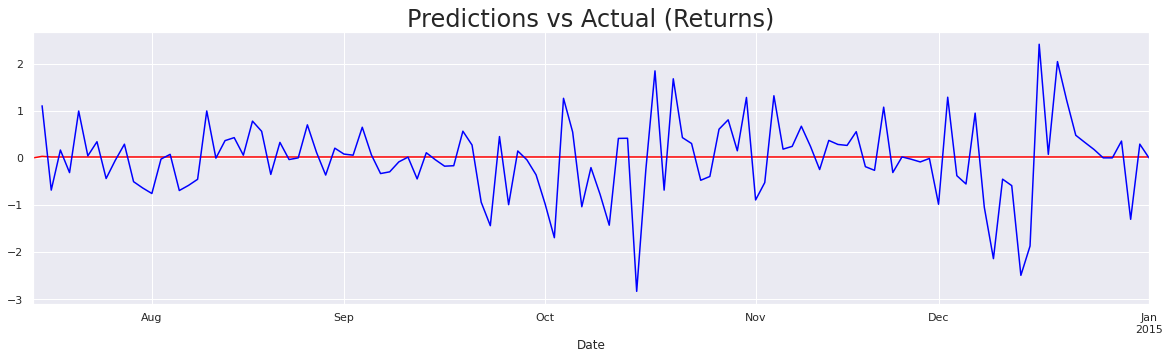

In [21]:
end_date = "2015-01-01"

model_ret_ma = ARIMA(df.ret_ftse[1:], order=(0,0,1))
results_ret_ma = model_ret_ma.fit()

df_pred_ma = results_ret_ma.predict(start = start_date, end = end_date) 

df_pred_ma[start_date:end_date].plot(figsize = (20,5), color = "red")   
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

In [22]:
df_pred_ma.head()

2014-07-15   -0.001399
2014-07-16    0.032252
2014-07-17    0.019118
2014-07-18    0.019118
2014-07-21    0.019118
Freq: B, dtype: float64

### ARMA

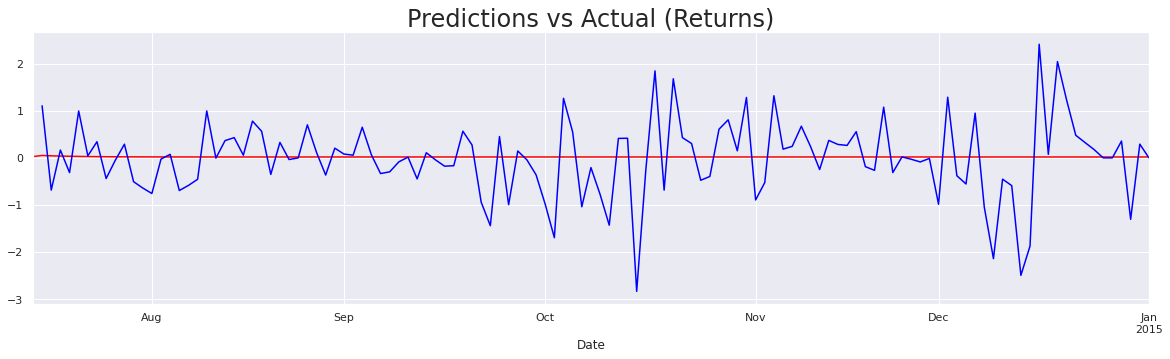

In [23]:
model_ret_arma = ARIMA(df.ret_ftse[1:], order=(1,0,1))
results_ret_arma = model_ret_arma.fit()

df_pred_arma = results_ret_arma.predict(start = start_date, end = end_date)

df_pred_arma[start_date:end_date].plot(figsize = (20,5), color = "red")   
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

In [24]:
df_pred_arma.head()

2014-07-15    0.027260
2014-07-16    0.051302
2014-07-17    0.044084
2014-07-18    0.038487
2014-07-21    0.034148
Freq: B, dtype: float64

In [25]:
df_pred_arma.tail()

2014-12-26    0.01917
2014-12-29    0.01917
2014-12-30    0.01917
2014-12-31    0.01917
2015-01-01    0.01917
Freq: B, dtype: float64

### ARMAX

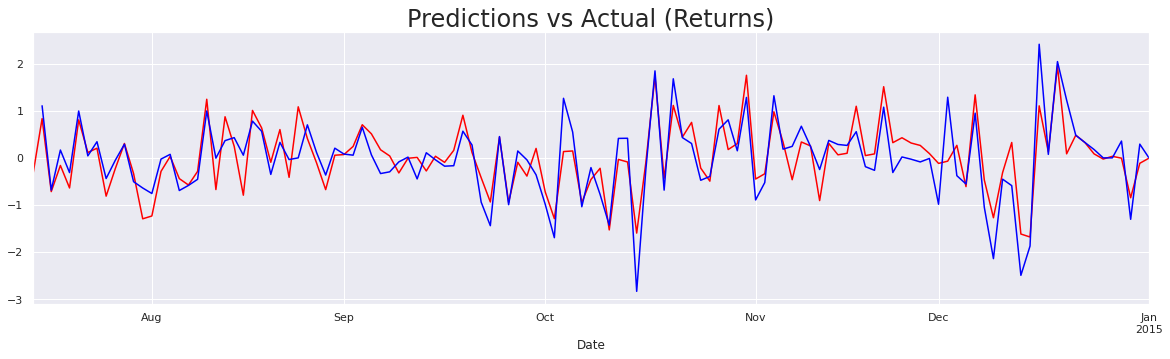

In [26]:
model_ret_armax = ARIMA(df.ret_ftse[1:], exog = df[["ret_spx","ret_dax","ret_nikkei"]][1:], order = (1,0,1))
results_ret_armax = model_ret_armax.fit()

df_pred_armax = results_ret_armax.predict(start = start_date, end = end_date, 
                                          exog = df_test[["ret_spx","ret_dax","ret_nikkei"]][start_date:end_date]) 

df_pred_armax[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

### SARMA

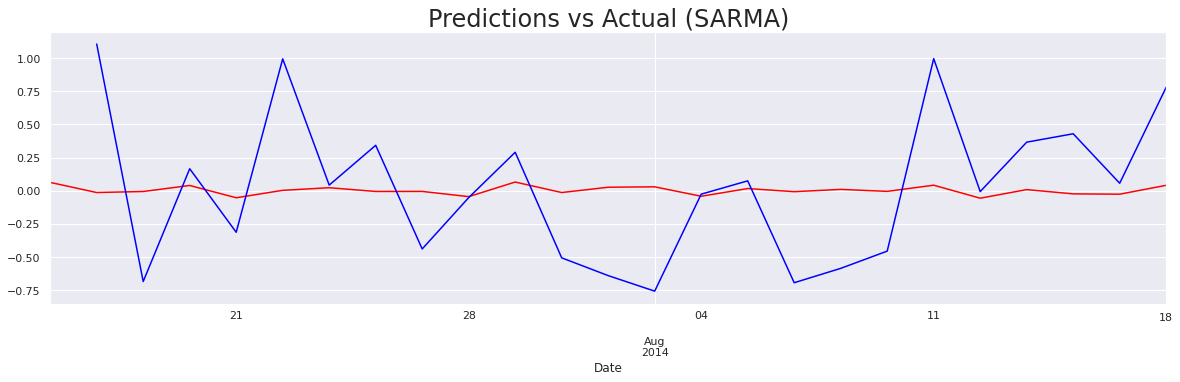

In [27]:
end_date = "2014-08-18"
model_ret_sarma = SARIMAX(df.ret_ftse[1:], order = (3,0,4), seasonal_order = (3,0,2,5))
results_ret_sarma = model_ret_sarma.fit()

df_pred_sarma = results_ret_sarma.predict(start = start_date, end = end_date)

df_pred_sarma[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (SARMA)", size = 24)
plt.show()

### SARIMAX

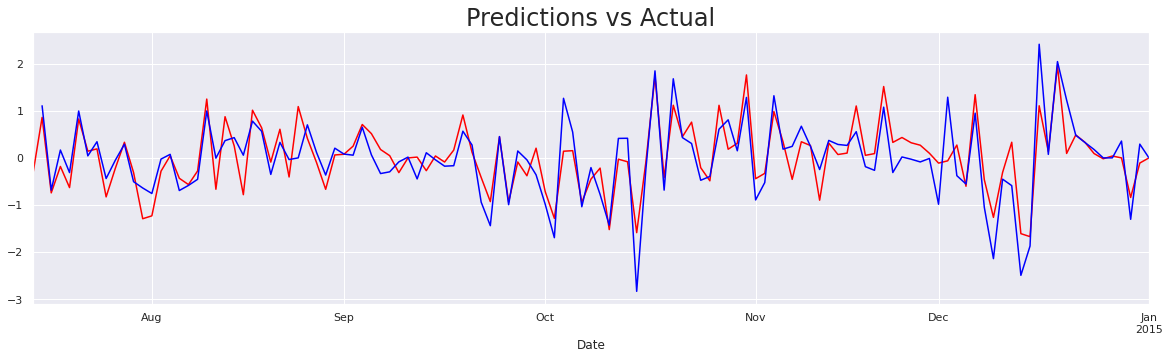

In [28]:
end_date = "2015-01-01"
model_ret_sarimax = SARIMAX(df.ret_ftse[1:], exog = df[["ret_spx","ret_dax","ret_nikkei"]][1:], 
                            order = (3,0,4), seasonal_order = (3,0,2,5))
results_ret_sarimax = model_ret_sarimax.fit()

df_pred_sarimax = results_ret_sarimax.predict(start = start_date, end = end_date, 
                                              exog = df_test[["ret_spx","ret_dax","ret_nikkei"]][start_date:end_date]) 

df_pred_sarimax[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()

### Auto ARIMA

In [29]:
model_auto = auto_arima(df.ret_ftse[1:], exogenous = df[['ret_spx', 'ret_dax', 'ret_nikkei']][1:],
                       m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5)

In [30]:
df_auto_pred = pd.DataFrame(model_auto.predict(n_periods = len(df_test[start_date:end_date]),
                            exogenous = df_test[['ret_spx', 'ret_dax', 'ret_nikkei']][start_date:end_date]),
                            index = df_test[start_date:end_date].index)

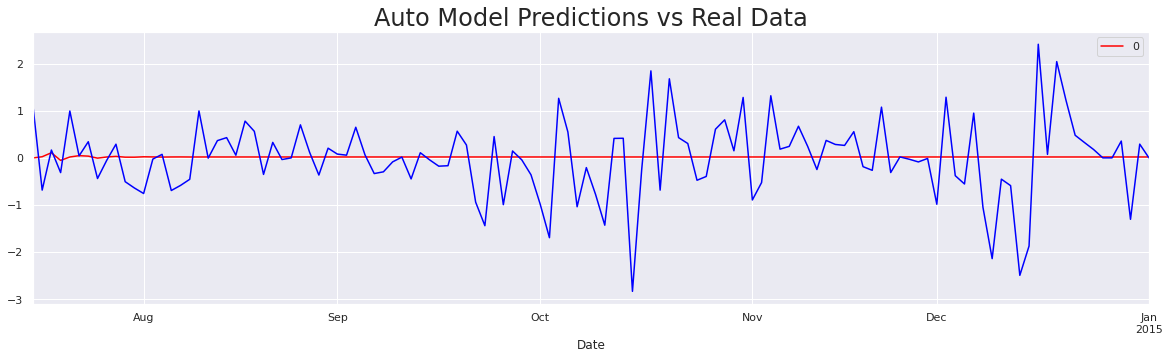

In [31]:
df_auto_pred.plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Auto Model Predictions vs Real Data", size = 24)
plt.show()

### Comparing All the Models (Returns)

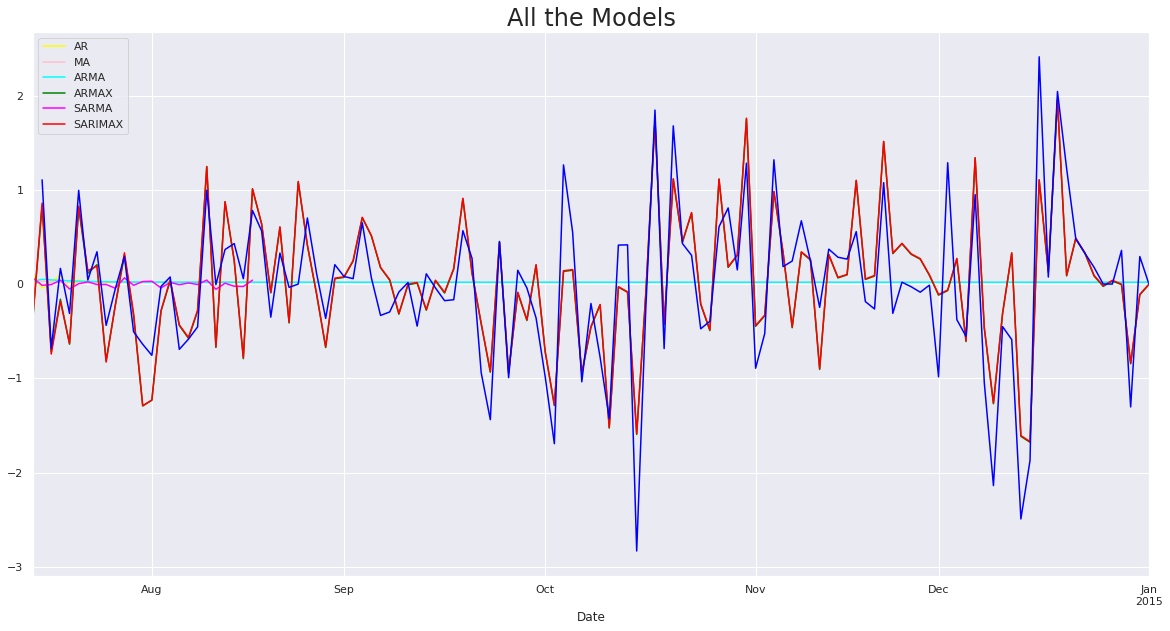

In [32]:
end_date = "2015-01-01"
df_pred_ar[start_date:end_date].plot(figsize = (20,10), color = "yellow")
df_pred_ma[start_date:end_date].plot(color = "pink")
df_pred_arma[start_date:end_date].plot(color = "cyan")
df_pred_armax[start_date:end_date].plot(color = "green")
df_pred_sarma[start_date:end_date].plot(color = "magenta")
df_pred_sarimax[start_date:end_date].plot(color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.legend(['AR','MA','ARMA','ARMAX','SARMA','SARIMAX'])
plt.title("All the Models", size = 24)
plt.show()

### Forecasting Volatility

In [33]:
mod_garch = arch_model(df_comp.ret_ftse[1:], vol = "GARCH", p = 1, q = 1, mean = "constant", dist = "Normal")
res_garch = mod_garch.fit(last_obs = start_date, update_freq = 10)

Iteration:     10,   Func. Count:     65,   Neg. LLF: 7309.738663281408
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7309.738653886703
            Iterations: 12
            Function evaluations: 74
            Gradient evaluations: 12


In [34]:
pred_garch = res_garch.forecast(horizon = 1, align = 'target')

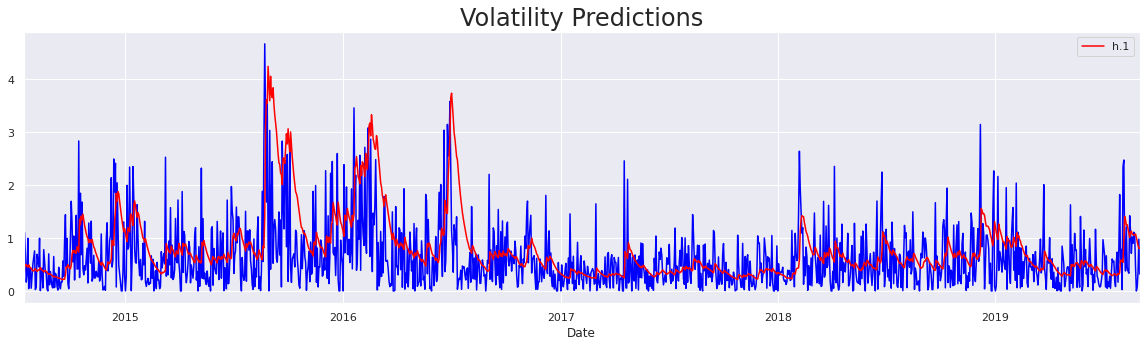

In [35]:
pred_garch.residual_variance[start_date:].plot(figsize = (20,5), color = "red", zorder = 2)
df_test.ret_ftse.abs().plot(color = "blue", zorder = 1)
plt.title("Volatility Predictions", size = 24)
plt.show()

In [36]:
pred_garch = res_garch.forecast(horizon = 100, align = 'target')
pred_garch.residual_variance[-1:]

,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,...,h.091,h.092,h.093,h.094,h.095,h.096,h.097,h.098,h.099,h.100
Date,,,,,,,,,,,,,,,,,,,,,
2019-08-30,0.810974,0.80513,0.867015,0.940752,1.021296,1.085907,1.07497,1.068781,1.082322,1.091898,...,0.842145,0.843744,0.83523,0.820559,0.832071,0.844172,0.855355,0.86872,0.876198,0.890501


### Multvariate Regression Model

In [37]:
from statsmodels.tsa.api import VAR

In [38]:
df_ret = df[['ret_spx', 'ret_dax', 'ret_ftse', 'ret_nikkei']][1:]

In [39]:
model_var_ret = VAR(df_ret)
model_var_ret.select_order(20)
results_var_ret = model_var_ret.fit(ic = 'aic')

In [40]:
results_var_ret.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 19, Nov, 2022
Time:                     09:38:44
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   0.328077
Nobs:                     5346.00    HQIC:                  0.260760
Log likelihood:          -30859.0    FPE:                    1.25185
AIC:                     0.224624    Det(Omega_mle):         1.23237
--------------------------------------------------------------------
Results for equation ret_spx
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.039221         0.016160            2.427           0.015
L1.ret_spx           -0.110815         0.017560           -6.310           0.000
L1.ret_dax            0.064819         0.019027           

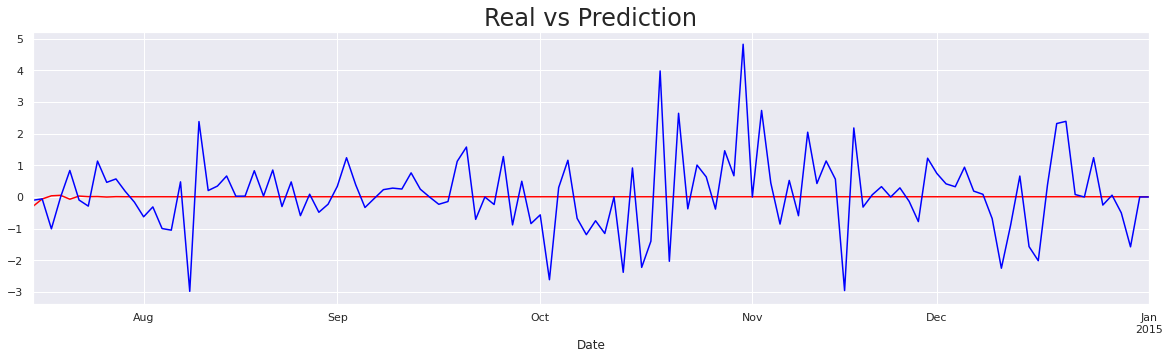

In [41]:
lag_order_ret = results_var_ret.k_ar
var_pred_ret = results_var_ret.forecast(df_ret.values[-lag_order_ret:], len(df_test[start_date:end_date]))

df_ret_pred = pd.DataFrame(data = var_pred_ret, index = df_test[start_date:end_date].index,
                                columns = df_test[start_date:end_date].columns[4:8])

df_ret_pred.ret_nikkei[start_date:end_date].plot(figsize = (20,5), color = "red")

df_test.ret_nikkei[start_date:end_date].plot(color = "blue")
plt.title("Real vs Prediction", size = 24)
plt.show()

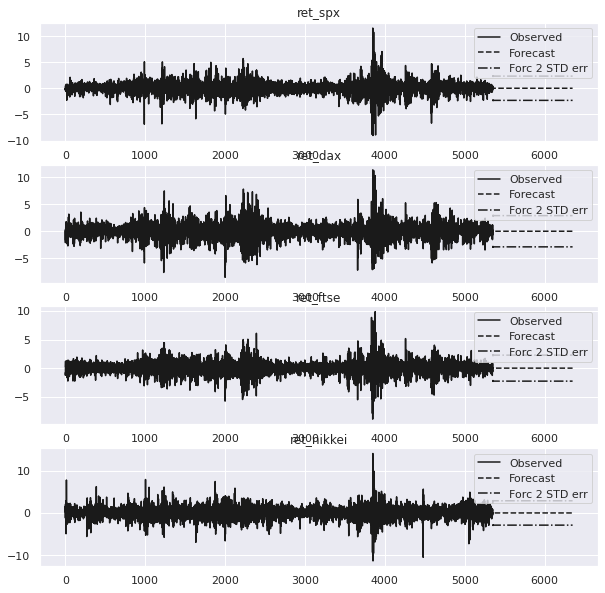

In [42]:
results_var_ret.plot_forecast(1000)
plt.show()